In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import InputLayer, LSTM, Dropout, LayerNormalization, GRU, Dense, LayerNormalization, ReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import mlflow
import mlflow.keras

In [26]:
tickers = ['AAPL','AMZN','FB','NVDA']
lookback=40
metric = 'low'
pc_metric = f'{metric}_percent_change'
target_name = f'{pc_metric}_target'
def to_ts(df, metric, lookback):
    data, targets = list(), list()
    for i in range(lookback,len(df.index)):
        data.append(df.iloc[i-lookback:i,:].values) ## first four metrics
        targets.append(df[metric].to_list()[i])
    data = np.array(data)
    targets = np.array(targets)
    return data, targets
def min_max_scale(col):
    scaled = col.subtract(col.min()).divide(col.max()-col.min())
    return scaled
def multi_stock_ts_split(df,tickers): ## could be sped up 
    data_tr, data_te, targets_tr, targets_te = [],[],[],[]
    for ticker in tickers:
        data, targets = to_ts(df[ticker].dropna(), 'low_percent_change', lookback) ## drops nan for each stock
        x = train_test_split(data, targets, shuffle=False)
        data_tr.append(x[0])
        data_te.append(x[1])
        targets_tr.append(x[2]) 
        targets_te.append(x[3])    
    return np.concatenate(data_tr), np.concatenate(data_te), np.concatenate(targets_tr), np.concatenate(targets_te)

In [27]:
mlflow.keras.autolog()

In [28]:
df = pd.read_pickle(f"./{tickers}_daily.pkl")
df = df.apply(min_max_scale)
features = len(df[tickers[0]].columns)
display(df)

AAPL                                                       \
                open      high       low     close    volume open_10_mean   
2001-04-02  0.013200  0.013687  0.012637  0.012294  0.016225     0.012851   
2001-04-03  0.012141  0.011866  0.010788  0.010334  0.017720     0.012313   
2001-04-04  0.009820  0.010204  0.008779  0.009260  0.034764     0.011346   
2001-04-05  0.011038  0.013456  0.010599  0.011249  0.021920     0.011173   
2001-04-06  0.011328  0.011346  0.010454  0.010842  0.015363     0.011128   
...              ...       ...       ...       ...       ...          ...   
2021-03-22  0.155696  0.159970  0.156570  0.160048  0.335065     0.159939   
2021-03-23  0.160048  0.160505  0.159307  0.158814  0.285518     0.160573   
2021-03-24  0.159308  0.158568  0.156286  0.155258  0.264618     0.160740   
2021-03-25  0.154550  0.156776  0.154735  0.155984  0.295694     0.160298   
2021-03-26  0.155725  0.156516  0.154619  0.156884  0.281312     0.160290   

                                                                       ...  \
           open_10_median open_10_std open_10_skew open_10_quantile_5  ...   
2001-04-02       0.012656         NaN          NaN           0.013701  ...   
2001-04-03       0.012120    0.001312          NaN           0.012650  ...   
2001-04-04       0.011584    0.003662     0.335031           0.010411  ...   
2001-04-05       0.011026    0.002999     0.477341           0.010360  ...   
2001-04-06       0.010762    0.002541     0.505799           0.010423  ...   
...                   ...         ...          ...                ...  ...   
2021-03-22       0.158687    0.006622     0.599416           0.161269  ...   
2021-03-23       0.159517    0.005913     0.582544           0.162288  ...   
2021-03-24       0.160347    0.005907     0.547431           0.162288  ...   
2021-03-25       0.159517    0.006593     0.565726           0.161695  ...   
2021-03-26       0.159517    0.006609     0.565663           0.161695  ...   

                                     NVDA  \
           volume_365_skew_percent_change   
2001-04-02                            NaN   
2001-04-03                            NaN   
2001-04-04                            NaN   
2001-04-05                       0.373315   
2001-04-06                       0.268041   
...                                   ...   
2021-03-22                       0.181467   
2021-03-23                       0.180104   
2021-03-24                       0.180374   
2021-03-25                       0.181490   
2021-03-26                       0.181377   

                                                 \
           volume_365_quantile_5_percent_change   
2001-04-02                                  NaN   
2001-04-03                             0.864369   
2001-04-04                             0.861248   
2001-04-05                             0.741755   
2001-04-06                             0.716227   
...                                         ...   
2021-03-22                             0.752544   
2021-03-23                             0.752544   
2021-03-24                             0.752544   
2021-03-25                             0.752544   
2021-03-26                             0.752544   

                                                  \
           volume_365_quantile_95_percent_change   
2001-04-02                                   NaN   
2001-04-03                              0.851781   
2001-04-04                              1.000000   
2001-04-05                              0.044659   
2001-04-06                              0.044002   
...                                          ...   
2021-03-22                              0.074923   
2021-03-23                              0.074923   
2021-03-24                              0.074923   
2021-03-25                              0.074923   
2021-03-26                              0.074923   

                                                                        

In [29]:
data_tr, data_te, targets_tr, targets_te = multi_stock_ts_split(df,tickers)
display(data_tr.shape, data_te.shape, targets_tr.shape, targets_te.shape)

(12852, 40, 464)

(4288, 40, 464)

(12852,)

(4288,)

In [30]:
# x=[x for x in range(len(targets_tr))]
# plt.plot(x, targets_tr.flatten(), color='b',alpha=0.5)
# plt.show()
# x=[x for x in range(len(targets_te))]
# plt.plot(x, targets_te.flatten(), color='b',alpha=0.5)
# plt.show()
# sns.lineplot(data=df[tickers[0]]['low_percent_change'])

In [31]:
def deep_gru(lookback=100):
    model = Sequential()
    model.add(InputLayer(input_shape=(lookback, 1)))
    model.add(GRU(512, return_sequences=True))
    model.add(GRU(256, return_sequences=True))
    model.add(GRU(256, return_sequences=True))
    model.add(GRU(256, return_sequences=True))
    model.add(GRU(256, return_sequences=True))
    model.add(GRU(128, return_sequences=True))
    model.add(GRU(128, return_sequences=True))
    model.add(GRU(128, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae', metrics=['mse','mape','mae'])
    return model
def deep(lookback=100, features=1):
    layers = [InputLayer(input_shape=(lookback, features)),
              *[Dense(2**-nodes,activation='relu') for nodes in range(-10,-7) for i in range(8)],
              Dense(1)]
    model = Sequential(layers)
    model.compile(optimizer='adam', loss='mae', metrics=['mse','mape','mae'])
    return model
def deep_LSTM(lookback=100):
    model = Sequential()
    model.add(InputLayer(input_shape=(lookback, 1)))
    model.add(LSTM(128,return_sequences=True))
    model.add(LSTM(128,return_sequences=True))
    model.add(LSTM(128,return_sequences=False))
    model.compile(optimizer='adam', loss='mae', metrics=['mse','mape','mae'])
    return model
def lstm(lookback=100):
    model = Sequential()
    model.add(InputLayer(input_shape=(lookback, 1)))
    model.add(LSTM(512,return_sequences=True))
    model.add(LSTM(264,return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae', metrics=['mse','mape','mae'])
    return model
def simple(lookback=100, features=1):
    model = Sequential()
    model.add(InputLayer(input_shape=(lookback, features)))
    model.add(Dense(512))
    model.add(Dense(264))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae', metrics=['mse','mape','mae'])
    return model


In [32]:
model = deep(lookback=lookback, features=features)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 40, 1024)          476160    
_________________________________________________________________
dense_42 (Dense)             (None, 40, 1024)          1049600   
_________________________________________________________________
dense_43 (Dense)             (None, 40, 1024)          1049600   
_________________________________________________________________
dense_44 (Dense)             (None, 40, 1024)          1049600   
_________________________________________________________________
dense_45 (Dense)             (None, 40, 1024)          1049600   
_________________________________________________________________
dense_46 (Dense)             (None, 40, 1024)          1049600   
_________________________________________________________________
dense_47 (Dense)             (None, 40, 1024)         

In [33]:
early = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(x=data_tr,y=targets_tr, validation_split=0.2, batch_size=None, epochs=50, callbacks=[early], shuffle=True, workers=-1)
model.evaluate(x=data_te, y=targets_te)

2021/03/29 06:59:24 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '10e879b919894ef2a1e8e9a4e6b3b3ce', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Epoch 1/50
322/322 [==============================] - 292s 898ms/step - loss: 0.2502 - mse: 0.4504 - mape: 286542.2689 - mae: 0.2502 - val_loss: 0.0283 - val_mse: 0.0016 - val_mape: 4.6717 - val_mae: 0.0283
Epoch 2/50
322/322 [==============================] - 273s 847ms/step - loss: 0.0297 - mse: 0.0023 - mape: 438308.4920 - mae: 0.0297 - val_loss: 0.0236 - val_mse: 0.0013 - val_mape: 4.0738 - val_mae: 0.0236
Epoch 3/50
322/322 [==============================] - 509s 2s/step - loss: 0.0281 - mse: 0.0021 - mape: 338717.6998 - mae: 0.0281 - val_loss: 0.0255 - val_mse: 0.0014 - val_mape: 4.2985 - val_mae: 0.0255
Epoch 4/50
322/322 [==============================] - 387s 1s/step - loss: 0.0280 - mse: 0.0020 - mape: 234674.6024 - mae: 0.0280 - val_loss: 0.0295 - val_mse: 0.0017 - val_mape: 5.0575 - val_mae: 0.0295
Epoch 5/50
322/322 [==============================] - 261s 811ms/step - loss: 0.0274 - mse: 0.0020 - mape: 436445.3926 - mae: 0.0274 - val_loss: 0.0270 - val_mse: 0.0015 - val_ma

[0.03460787236690521,
 0.003791442606598139,
 6.1661295890808105,
 0.03460787236690521]

In [34]:
display(data_te.shape, data_tr.shape, targets_te.shape, targets_tr.shape )
# pd.DataFrame(predictions.reshape(predictions.shape[0], predictions.shape[1]))
# targets_te.shape
# predictions.flatten().shape
# predictions=predictions[:,-1,0]


(4288, 40, 464)

(12852, 40, 464)

(4288,)

(12852,)

In [35]:
predictions = model.predict(data_te)
display(predictions.shape)
predictions_tr = model.predict(data_tr)

(4288, 40, 1)

In [36]:
predictions=predictions[:,-1].flatten()
predictions_tr=predictions_tr[:,-1].flatten()

<function matplotlib.pyplot.show(close=None, block=None)>

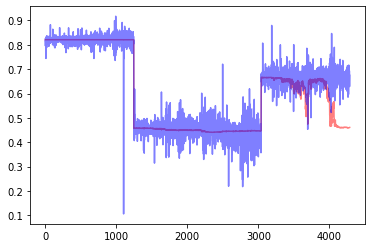

In [37]:
x=[x for x in range(len(targets_te))]
plt.plot(x, predictions, color='r',alpha=0.5)
plt.plot(x, targets_te, color='b',alpha=0.5)
plt.show

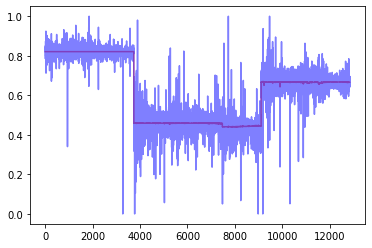

In [38]:
x=[x for x in range(len(targets_tr))]
plt.plot(x, predictions_tr, color='r',alpha=0.5)
plt.plot(x, targets_tr, color='b',alpha=0.5)
plt.show()

In [39]:
err = np.subtract(predictions, targets_te)
err_tr = np.subtract(predictions_tr, targets_tr)
err_tr = pd.DataFrame({'err_tr':err_tr})
err = pd.DataFrame({'err':err})

In [40]:
err['abs_err']=err['err'].abs()
err['mean_pred_err']=np.subtract(predictions, targets_te.mean())
err['abs_mean_pred_err']=err['mean_pred_err'].abs()

In [41]:
err.describe()

,err,abs_err,mean_pred_err,abs_mean_pred_err
count,4288.000000,4.288000e+03,4288.000000,4288.000000
mean,-0.017749,3.549569e-02,-0.017749,0.147248
std,0.060571,5.218862e-02,0.159554,0.063919
min,-0.365569,9.545450e-07,-0.179528,0.000049
25%,-0.026097,6.652145e-03,-0.170677,0.155831
50%,-0.005529,1.665199e-02,-0.022803,0.171461
75%,0.008466,3.812457e-02,0.200582,0.200582
max,0.715282,7.152816e-01,0.200612,0.200612
